# Orthomosaic-Basemap Feature Matching and Registration

This notebook performs feature matching between orthomosaics (with/without GCPs) and a ground control basemap using SIFT and evaluates 2D shifting and registration.

## Goals:
1. **Feature Matching**: Use SIFT to find corresponding features between orthos and basemap
2. **Multi-Resolution Analysis**: Evaluate matching at full, half, and quarter resolution
3. **2D Registration**: Apply computed shifts to register orthos to basemap
4. **Visualization**: Create visualizations of matches and registered orthos

## Inputs:
- **Ground Control Basemap**: `TestsiteNewWest_Spexigeo_RTK.tiff`
- **Orthomosaic (No GCPs)**: `outputs/orthomosaics/orthomosaic_no_gcps.tif`
- **Orthomosaic (With GCPs)**: `outputs/orthomosaics/orthomosaic_with_gcps.tif`

## Outputs:
- All outputs saved to `outputs/test_matching/`
- Match visualizations at different resolutions
- Registered orthomosaics


## Setup: Install Dependencies


In [1]:
# Install required packages if needed
import subprocess
import sys

packages = ['opencv-python', 'scikit-image', 'rasterio', 'numpy', 'matplotlib', 'pillow', 'scipy']
for package in packages:
    try:
        if package == 'opencv-python':
            __import__('cv2')
        elif package == 'scikit-image':
            __import__('skimage')
        elif package == 'pillow':
            __import__('PIL')
        else:
            __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

print("✓ Dependencies installed")


✓ Dependencies installed


## Imports


In [2]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform_bounds
from rasterio import Affine
import cv2
from PIL import Image
import warnings
import json
from typing import Dict, Tuple, Optional, List
import logging

warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

print("✓ Imports successful!")


✓ Imports successful!


## Step 1: Setup Paths and Output Directories


In [3]:
# Define paths
data_dir = Path("/Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25")
output_dir = Path("outputs")

# Input files
basemap_path = data_dir / "Michael_RTK_orthos" / "TestsiteNewWest_Spexigeo_RTK.tiff"
ortho_no_gcps_path = output_dir / "orthomosaics" / "orthomosaic_no_gcps.tif"
ortho_with_gcps_path = output_dir / "orthomosaics" / "orthomosaic_with_gcps.tif"

# Output directory structure
matching_output_dir = output_dir / "test_matching"
matching_output_dir.mkdir(parents=True, exist_ok=True)

# Subdirectories
reprojected_dir = matching_output_dir / "reprojected"
reprojected_dir.mkdir(exist_ok=True)

converted_dir = matching_output_dir / "converted"
converted_dir.mkdir(exist_ok=True)

matches_dir = matching_output_dir / "matches"
matches_dir.mkdir(exist_ok=True)

registered_dir = matching_output_dir / "registered"
registered_dir.mkdir(exist_ok=True)

print(f"✓ Output directory: {matching_output_dir}")
print(f"  - Reprojected: {reprojected_dir}")
print(f"  - Converted: {converted_dir}")
print(f"  - Matches: {matches_dir}")
print(f"  - Registered: {registered_dir}")


✓ Output directory: outputs/test_matching
  - Reprojected: outputs/test_matching/reprojected
  - Converted: outputs/test_matching/converted
  - Matches: outputs/test_matching/matches
  - Registered: outputs/test_matching/registered


## Step 2: Load and Check Input Files


In [4]:
# Check if files exist
if not basemap_path.exists():
    raise FileNotFoundError(f"Basemap not found: {basemap_path}")
if not ortho_no_gcps_path.exists():
    raise FileNotFoundError(f"Orthomosaic (no GCPs) not found: {ortho_no_gcps_path}")
if not ortho_with_gcps_path.exists():
    raise FileNotFoundError(f"Orthomosaic (with GCPs) not found: {ortho_with_gcps_path}")

print("✓ All input files found")

# Get basic info about each file
print("\n📊 File Information:")
for name, path in [("Basemap", basemap_path), ("Ortho (No GCPs)", ortho_no_gcps_path), ("Ortho (With GCPs)", ortho_with_gcps_path)]:
    with rasterio.open(path) as src:
        file_size_mb = path.stat().st_size / (1024 * 1024)
        print(f"\n{name}:")
        print(f"  Path: {path}")
        print(f"  Size: {file_size_mb:.2f} MB")
        print(f"  CRS: {src.crs}")
        print(f"  Dimensions: {src.width} x {src.height}")
        print(f"  Bands: {src.count}")
        print(f"  Bounds: {src.bounds}")
        if src.crs:
            pixel_size_x = abs(src.transform[0])
            pixel_size_y = abs(src.transform[4])
            print(f"  Pixel size: {pixel_size_x:.4f} m (X), {pixel_size_y:.4f} m (Y)")


✓ All input files found

📊 File Information:

Basemap:
  Path: /Users/mauriciohessflores/Documents/Code/Data/New Westminster Oct _25/Michael_RTK_orthos/TestsiteNewWest_Spexigeo_RTK.tiff
  Size: 19804.91 MB
  CRS: EPSG:32610
  Dimensions: 90129 x 90188
  Bands: 4
  Bounds: BoundingBox(left=506424.37839793676, bottom=5450017.622213458, right=507501.0951215451, top=5451095.043774429)
  Pixel size: 0.0119 m (X), 0.0119 m (Y)

Ortho (No GCPs):
  Path: outputs/orthomosaics/orthomosaic_no_gcps.tif
  Size: 3887.28 MB
  CRS: EPSG:4326
  Dimensions: 38531 x 39277
  Bands: 4
  Bounds: BoundingBox(left=-122.91170031378732, bottom=49.20303508811748, right=-122.89720111440005, top=49.212718829461046)
  Pixel size: 0.0000 m (X), 0.0000 m (Y)

Ortho (With GCPs):
  Path: outputs/orthomosaics/orthomosaic_with_gcps.tif
  Size: 3867.91 MB
  CRS: EPSG:4326
  Dimensions: 38538 x 39233
  Bands: 4
  Bounds: BoundingBox(left=-122.9117167927641, bottom=49.203044960109175, right=-122.89720605758104, top=49.21272

## Step 3: Reproject Orthomosaics to Match Basemap CRS


In [ ]:
# Get basemap CRS (target CRS)
with rasterio.open(basemap_path) as basemap_src:
    target_crs = basemap_src.crs
    target_bounds = basemap_src.bounds
    target_transform = basemap_src.transform
    target_width = basemap_src.width
    target_height = basemap_src.height

print(f"Target CRS: {target_crs}")
print(f"Target bounds: {target_bounds}")
print(f"Target dimensions: {target_width} x {target_height}")

# Reproject each orthomosaic
ortho_paths = {
    'no_gcps': ortho_no_gcps_path,
    'with_gcps': ortho_with_gcps_path
}

reprojected_paths = {}

for ortho_name, ortho_path in ortho_paths.items():
    print(f"\n{'='*60}")
    print(f"Reprojecting {ortho_name}...")
    
    reprojected_path = reprojected_dir / f"{ortho_name}_reprojected.tif"
    
    # Check if already reprojected
    if reprojected_path.exists():
        print(f"  ✓ Already reprojected: {reprojected_path}")
        reprojected_paths[ortho_name] = reprojected_path
        continue
    
    with rasterio.open(ortho_path) as ortho_src:
        source_crs = ortho_src.crs
        source_bounds = ortho_src.bounds
        
        print(f"  Source CRS: {source_crs}")
        print(f"  Source bounds: {source_bounds}")
        
        # Check if reprojection is needed
        if source_crs == target_crs:
            print(f"  ✓ Already in target CRS, copying...")
            import shutil
            shutil.copy(ortho_path, reprojected_path)
            reprojected_paths[ortho_name] = reprojected_path
            continue
        
        # Calculate transform using source bounds (not target bounds)
        # First, transform source bounds to target CRS to get output extent
        try:
            print(f"  Transforming source bounds to target CRS...")
            src_bounds_target_crs = transform_bounds(
                source_crs, target_crs,
                source_bounds.left, source_bounds.bottom,
                source_bounds.right, source_bounds.top
            )
            
            print(f"  Source bounds in target CRS: {src_bounds_target_crs}")
            
            # Get target pixel size
            target_pixel_size_x = abs(target_transform[0])
            target_pixel_size_y = abs(target_transform[4])
            
            # Use intersection of bounds (where both images overlap)
            output_left = max(src_bounds_target_crs[0], target_bounds.left)
            output_bottom = max(src_bounds_target_crs[1], target_bounds.bottom)
            output_right = min(src_bounds_target_crs[2], target_bounds.right)
            output_top = min(src_bounds_target_crs[3], target_bounds.top)
            
            print(f"  Output bounds (intersection): left={output_left:.2f}, bottom={output_bottom:.2f}, right={output_right:.2f}, top={output_top:.2f}")
            
            # Validate bounds
            if output_right <= output_left or output_top <= output_bottom:
                raise ValueError(f"Invalid output bounds: width={output_right-output_left}, height={output_top-output_bottom}")
            
            # Calculate dimensions using target pixel size
            width = int((output_right - output_left) / target_pixel_size_x)
            height = int((output_top - output_bottom) / target_pixel_size_y)
            
            # Validate dimensions
            if width <= 0 or height <= 0:
                raise ValueError(f"Invalid dimensions: width={width}, height={height}")
            
            # Create transform for output
            transform = Affine.translation(output_left, output_top) * Affine.scale(target_pixel_size_x, -target_pixel_size_y)
            
            print(f"  ✓ Transform calculated: {width}x{height} pixels")
            
        except Exception as e:
            print(f"  ❌ Transform calculation failed: {e}")
            print(f"  Trying alternative approach using source resolution...")
            
            # Alternative: use source resolution and calculate output bounds
            try:
                # Get source pixel size
                source_pixel_size_x = abs(ortho_src.transform[0])
                source_pixel_size_y = abs(ortho_src.transform[4])
                
                # Transform source bounds to target CRS
                src_bounds_target_crs = transform_bounds(
                    source_crs, target_crs,
                    source_bounds.left, source_bounds.bottom,
                    source_bounds.right, source_bounds.top
                )
                
                # Use source pixel size (approximate)
                output_left = src_bounds_target_crs[0]
                output_bottom = src_bounds_target_crs[1]
                output_right = src_bounds_target_crs[2]
                output_top = src_bounds_target_crs[3]
                
                # Calculate dimensions
                width = int((output_right - output_left) / source_pixel_size_x)
                height = int((output_top - output_bottom) / source_pixel_size_y)
                
                transform = Affine.translation(output_left, output_top) * Affine.scale(source_pixel_size_x, -source_pixel_size_y)
                
                print(f"  ✓ Using source resolution approach: {width}x{height} pixels")
                
            except Exception as e2:
                print(f"  ❌ Alternative approach also failed: {e2}")
                print(f"  Skipping {ortho_name}...")
                continue
        
        # Reproject
        print(f"  Reprojecting to {width}x{height}...")
        
        # Read source data
        source_data = ortho_src.read()
        source_count = ortho_src.count
        
        # Reproject each band
        reprojected_data = np.zeros((source_count, height, width), dtype=source_data.dtype)
        
        for band_idx in range(1, source_count + 1):
            reproject(
                source=rasterio.band(ortho_src, band_idx),
                destination=reprojected_data[band_idx - 1],
                src_transform=ortho_src.transform,
                src_crs=source_crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.bilinear
            )
        
        # Save reprojected file with LZW compression
        # Also save as JPEG directly to avoid large intermediate files
        jpeg_path = reprojected_dir / f"{ortho_name}_reprojected.jpg"
        
        # Save GeoTIFF with compression
        with rasterio.open(
            reprojected_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=source_count,
            dtype=reprojected_data.dtype,
            crs=target_crs,
            transform=transform,
            compress='lzw',
            BIGTIFF='YES',
            tiled=True,
            blockxsize=512,
            blockysize=512,
            predictor=2  # Horizontal differencing for better compression
        ) as dst:
            dst.write(reprojected_data)
        
        # Also save as JPEG for faster processing (normalize first)
        if source_count >= 3:
            jpeg_data = reprojected_data[:3]  # RGB
        else:
            jpeg_data = np.stack([reprojected_data[0]] * 3)  # Grayscale to RGB
        
        # Normalize to 0-255
        if jpeg_data.dtype != np.uint8:
            jpeg_data_min = jpeg_data.min(axis=(1, 2), keepdims=True)
            jpeg_data_max = jpeg_data.max(axis=(1, 2), keepdims=True)
            jpeg_data_range = jpeg_data_max - jpeg_data_min
            jpeg_data_range[jpeg_data_range == 0] = 1
            jpeg_data = ((jpeg_data - jpeg_data_min) / jpeg_data_range * 255).astype(np.uint8)
        
        # Convert to (H, W, C) format
        jpeg_array = jpeg_data.transpose(1, 2, 0)
        jpeg_img = Image.fromarray(jpeg_array)
        jpeg_img.save(jpeg_path, 'JPEG', quality=95)
        print(f"  ✓ Also saved JPEG: {jpeg_path}")
        
        print(f"  ✓ Saved: {reprojected_path}")
        reprojected_paths[ortho_name] = reprojected_path

print(f"\n✓ Reprojection complete!")


Target CRS: EPSG:32610
Target bounds: BoundingBox(left=506424.37839793676, bottom=5450017.622213458, right=507501.0951215451, top=5451095.043774429)
Target dimensions: 90129 x 90188

Reprojecting no_gcps...
  ✓ Already reprojected: outputs/test_matching/reprojected/no_gcps_reprojected.tif

Reprojecting with_gcps...
  Source CRS: EPSG:4326
  Source bounds: BoundingBox(left=-122.9117167927641, bottom=49.203044960109175, right=-122.89720605758104, top=49.21272378933356)
  Transforming source bounds to target CRS...
  Source bounds in target CRS: (506429.71224202216, 5450031.47560229, 507487.9980312089, 5451108.798120763)
  Output bounds (intersection): left=506429.71, bottom=5450031.48, right=507488.00, top=5451095.04
  ✓ Transform calculated: 88586x89028 pixels
  Reprojecting to 88586x89028...
  ✓ Saved: outputs/test_matching/reprojected/with_gcps_reprojected.tif

✓ Reprojection complete!


In [ ]:
def convert_geotiff_to_jpeg(geotiff_path: Path, output_path: Path, downsample_factor: float = 1.0) -> Tuple[np.ndarray, Dict]:
    """
    Convert GeoTIFF to JPEG format at specified resolution.
    
    Args:
        geotiff_path: Path to input GeoTIFF
        output_path: Path to save JPEG
        downsample_factor: Factor to downsample (1.0 = full res, 0.5 = half, 0.25 = quarter)
        
    Returns:
        Tuple of (image array, metadata dict with transform info)
    """
    with rasterio.open(geotiff_path) as src:
        # Read first 3 bands (RGB) or convert to grayscale
        if src.count >= 3:
            data = src.read([1, 2, 3])
        else:
            data = src.read(1)
            data = np.stack([data, data, data])
        
        # Get metadata
        metadata = {
            'transform': src.transform,
            'crs': src.crs,
            'bounds': src.bounds,
            'width': src.width,
            'height': src.height
        }
        
        # Normalize to 0-255
        if data.dtype != np.uint8:
            data_min = data.min(axis=(1, 2), keepdims=True)
            data_max = data.max(axis=(1, 2), keepdims=True)
            data_range = data_max - data_min
            data_range[data_range == 0] = 1  # Avoid division by zero
            data = ((data - data_min) / data_range * 255).astype(np.uint8)
        
        # Downsample if needed
        height, width = data.shape[1], data.shape[2]
        
        if downsample_factor < 1.0:
            new_height = int(height * downsample_factor)
            new_width = int(width * downsample_factor)
            
            print(f"    Downsampling from {width}x{height} to {new_width}x{new_height} (factor: {downsample_factor})")
            
            # Use cv2 for resizing
            if len(data.shape) == 3:
                # RGB
                data_resized = np.zeros((3, new_height, new_width), dtype=np.uint8)
                for i in range(3):
                    data_resized[i] = cv2.resize(data[i], (new_width, new_height), interpolation=cv2.INTER_AREA)
                data = data_resized
            else:
                data = cv2.resize(data, (new_width, new_height), interpolation=cv2.INTER_AREA)
            
            # Update metadata
            metadata['width'] = new_width
            metadata['height'] = new_height
            # Adjust transform
            old_transform = metadata['transform']
            metadata['transform'] = Affine(
                old_transform[0] / downsample_factor, old_transform[1], old_transform[2],
                old_transform[3], old_transform[4] / downsample_factor, old_transform[5]
            )
        
        # Convert to PIL Image format (H, W, C)
        if len(data.shape) == 3:
            img_array = data.transpose(1, 2, 0)
        else:
            img_array = data
        
        # Save as JPEG
        img = Image.fromarray(img_array)
        img.save(output_path, 'JPEG', quality=95)
        
        print(f"    ✓ Saved JPEG: {output_path} ({img_array.shape[1]}x{img_array.shape[0]})")
        
        return img_array, metadata

# Convert basemap and reprojected orthos at different resolutions
resolutions = {
    'full': 1.0,
    'half': 0.5,
    'quarter': 0.25
}

converted_files = {}

print("Converting files to JPEG at different resolutions...")

# Convert basemap at all resolutions
for res_name, factor in resolutions.items():
    basemap_jpeg = converted_dir / f"basemap_{res_name}.jpg"
    if not basemap_jpeg.exists():
        print(f"\nConverting basemap at {res_name} resolution...")
        basemap_img, basemap_meta = convert_geotiff_to_jpeg(basemap_path, basemap_jpeg, downsample_factor=factor)
        if res_name not in converted_files:
            converted_files[res_name] = {}
        converted_files[res_name]['basemap'] = {'path': basemap_jpeg, 'img': basemap_img, 'meta': basemap_meta}
    else:
        print(f"\nBasemap JPEG ({res_name}) already exists: {basemap_jpeg}")
        basemap_img = np.array(Image.open(basemap_jpeg))
        with rasterio.open(basemap_path) as src:
            basemap_meta = {
                'transform': src.transform,
                'crs': src.crs,
                'bounds': src.bounds,
                'width': basemap_img.shape[1],
                'height': basemap_img.shape[0]
            }
        if res_name not in converted_files:
            converted_files[res_name] = {}
        converted_files[res_name]['basemap'] = {'path': basemap_jpeg, 'img': basemap_img, 'meta': basemap_meta}

# Convert reprojected orthos at all resolutions
for ortho_name, reprojected_path in reprojected_paths.items():
    for res_name, factor in resolutions.items():
        ortho_jpeg = converted_dir / f"{ortho_name}_{res_name}.jpg"
        if not ortho_jpeg.exists():
            print(f"\nConverting {ortho_name} at {res_name} resolution...")
            ortho_img, ortho_meta = convert_geotiff_to_jpeg(reprojected_path, ortho_jpeg, downsample_factor=factor)
            converted_files[res_name][ortho_name] = {'path': ortho_jpeg, 'img': ortho_img, 'meta': ortho_meta}
        else:
            print(f"\n{ortho_name} JPEG ({res_name}) already exists: {ortho_jpeg}")
            ortho_img = np.array(Image.open(ortho_jpeg))
            with rasterio.open(reprojected_path) as src:
                ortho_meta = {
                    'transform': src.transform,
                    'crs': src.crs,
                    'bounds': src.bounds,
                    'width': ortho_img.shape[1],
                    'height': ortho_img.shape[0]
                }
            if res_name not in converted_files:
                converted_files[res_name] = {}
            converted_files[res_name][ortho_name] = {'path': ortho_jpeg, 'img': ortho_img, 'meta': ortho_meta}

print(f"\n✓ Conversion complete!")


Converting files to JPEG...

Converting basemap...
    Downsampling from 90129x90188 to 9993x10000
    ✓ Saved JPEG: outputs/test_matching/converted/basemap.jpg (9993x10000)

Converting no_gcps...
    Downsampling from 88515x89120 to 9932x10000
    ✓ Saved JPEG: outputs/test_matching/converted/no_gcps.jpg (9932x10000)

Converting with_gcps...
    Downsampling from 88586x89028 to 9950x10000
    ✓ Saved JPEG: outputs/test_matching/converted/with_gcps.jpg (9950x10000)

✓ Conversion complete!


In [ ]:
def perform_sift_matching(img1: np.ndarray, img2: np.ndarray, max_features: int = 5000) -> Dict:
    """
    Perform SIFT feature matching between two images.
    
    Args:
        img1: First image (numpy array)
        img2: Second image (numpy array)
        max_features: Maximum number of features to detect
        
    Returns:
        Dictionary with matching results
    """
    # Convert to grayscale if needed
    if len(img1.shape) == 3:
        gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    else:
        gray1 = img1
    
    if len(img2.shape) == 3:
        gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    else:
        gray2 = img2
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create(nfeatures=max_features, contrastThreshold=0.01, edgeThreshold=20)
    
    # Detect keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        return {
            'num_keypoints1': len(kp1) if kp1 else 0,
            'num_keypoints2': len(kp2) if kp2 else 0,
            'num_matches': 0,
            'good_matches': [],
            'kp1': kp1,
            'kp2': kp2,
            'error': 'No descriptors found'
        }
    
    # Match features using FLANN or BFMatcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < 0.75 * n.distance:  # Lowe's ratio test
                good_matches.append(m)
    
    # Calculate offsets
    offset_x = None
    offset_y = None
    rmse_2d = None
    H = None
    mask = None
    
    if len(good_matches) >= 4:
        # Extract matched points
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Find homography
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        if H is not None:
            # Calculate mean offset from homography
            # Use center point as reference
            h, w = gray1.shape
            center = np.array([[[w/2, h/2]]], dtype=np.float32)
            transformed_center = cv2.perspectiveTransform(center, H)
            
            offset_x = float(transformed_center[0][0][0] - center[0][0][0])
            offset_y = float(transformed_center[0][0][1] - center[0][0][1])
            
            # Calculate RMSE from inliers
            inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
            
            if len(inlier_matches) > 0:
                inlier_src = np.float32([kp1[m.queryIdx].pt for m in inlier_matches])
                inlier_dst = np.float32([kp2[m.trainIdx].pt for m in inlier_matches])
                
                # Transform source points
                inlier_src_transformed = cv2.perspectiveTransform(
                    inlier_src.reshape(-1, 1, 2), H
                ).reshape(-1, 2)
                
                # Calculate RMSE
                errors = inlier_dst - inlier_src_transformed
                rmse_2d = float(np.sqrt(np.mean(errors**2)))
    
    num_inliers = len([m for i, m in enumerate(good_matches) if mask is not None and mask[i]]) if mask is not None and len(good_matches) > 0 else 0
    
    return {
        'num_keypoints1': len(kp1),
        'num_keypoints2': len(kp2),
        'num_matches': len(good_matches),
        'num_inliers': num_inliers,
        'good_matches': good_matches,
        'kp1': kp1,
        'kp2': kp2,
        'offset_x': offset_x,
        'offset_y': offset_y,
        'rmse_2d': rmse_2d,
        'homography': H.tolist() if H is not None else None,
        'confidence': len(good_matches) / max(len(kp1), len(kp2)) if len(kp1) > 0 and len(kp2) > 0 else 0.0
    }

# Perform matching at different resolutions
# Use pre-saved JPEG files at each resolution
resolutions = {
    'full': 1.0,
    'half': 0.5,
    'quarter': 0.25
}

matching_results = {}

for ortho_name in ['no_gcps', 'with_gcps']:
    print(f"\n{'='*60}")
    print(f"Matching {ortho_name} to basemap")
    print(f"{'='*60}")
    
    matching_results[ortho_name] = {}
    
    for res_name, factor in resolutions.items():
        print(f"\n📊 Resolution: {res_name} (factor: {factor})")
        
        # Load pre-saved images at this resolution
        basemap_img = converted_files[res_name]['basemap']['img']
        ortho_img = converted_files[res_name][ortho_name]['img']
        
        print(f"  Basemap: {basemap_img.shape[1]}x{basemap_img.shape[0]}")
        print(f"  Ortho: {ortho_img.shape[1]}x{ortho_img.shape[0]}")
        
        # Perform matching
        result = perform_sift_matching(ortho_img, basemap_img)
        
        print(f"  Keypoints (ortho): {result['num_keypoints1']}")
        print(f"  Keypoints (basemap): {result['num_keypoints2']}")
        print(f"  Matches: {result['num_matches']}")
        print(f"  Inliers: {result['num_inliers']}")
        
        if result['offset_x'] is not None:
            print(f"  Offset X: {result['offset_x']:.2f} px")
            print(f"  Offset Y: {result['offset_y']:.2f} px")
            print(f"  RMSE 2D: {result['rmse_2d']:.2f} px")
            print(f"  Confidence: {result['confidence']:.3f}")
            
            # Scale offsets back to full resolution
            result['offset_x_full'] = result['offset_x'] / factor
            result['offset_y_full'] = result['offset_y'] / factor
            result['rmse_2d_full'] = result['rmse_2d'] / factor if result['rmse_2d'] else None
        else:
            print(f"  ⚠️  Matching failed: {result.get('error', 'Unknown error')}")
        
        matching_results[ortho_name][res_name] = result
        
        # Save matching visualization
        if result['num_matches'] > 0:
            vis_path = matches_dir / f"{ortho_name}_{res_name}_matches.jpg"
            
            # Create visualization
            img_matches = cv2.drawMatches(
                ortho_img, result['kp1'],
                basemap_img, result['kp2'],
                result['good_matches'][:50],  # Show first 50 matches
                None,
                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
            )
            
            cv2.imwrite(str(vis_path), img_matches)
            print(f"  ✓ Saved visualization: {vis_path}")

print(f"\n✓ Feature matching complete!")



Matching no_gcps to basemap

📊 Resolution: full (factor: 1.0)
  Basemap: 9993x10000
  Ortho: 9932x10000
  Keypoints (ortho): 5000
  Keypoints (basemap): 5001
  Matches: 118
  Inliers: 20
  Offset X: 22.19 px
  Offset Y: -51.32 px
  RMSE 2D: 1.55 px
  Confidence: 0.024
  ✓ Saved visualization: outputs/test_matching/matches/no_gcps_full_matches.jpg

📊 Resolution: half (factor: 0.5)
  Basemap: 4996x5000
  Ortho: 4966x5000
  Keypoints (ortho): 5000
  Keypoints (basemap): 5000
  Matches: 110
  Inliers: 25
  Offset X: 11.09 px
  Offset Y: -26.38 px
  RMSE 2D: 0.68 px
  Confidence: 0.022
  ✓ Saved visualization: outputs/test_matching/matches/no_gcps_half_matches.jpg

📊 Resolution: quarter (factor: 0.25)
  Basemap: 2498x2500
  Ortho: 2483x2500
  Keypoints (ortho): 5001
  Keypoints (basemap): 5000
  Matches: 92
  Inliers: 37
  Offset X: 5.00 px
  Offset Y: -12.93 px
  RMSE 2D: 0.70 px
  Confidence: 0.018
  ✓ Saved visualization: outputs/test_matching/matches/no_gcps_quarter_matches.jpg

Matchi

DecompressionBombError: Image size (199250000 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

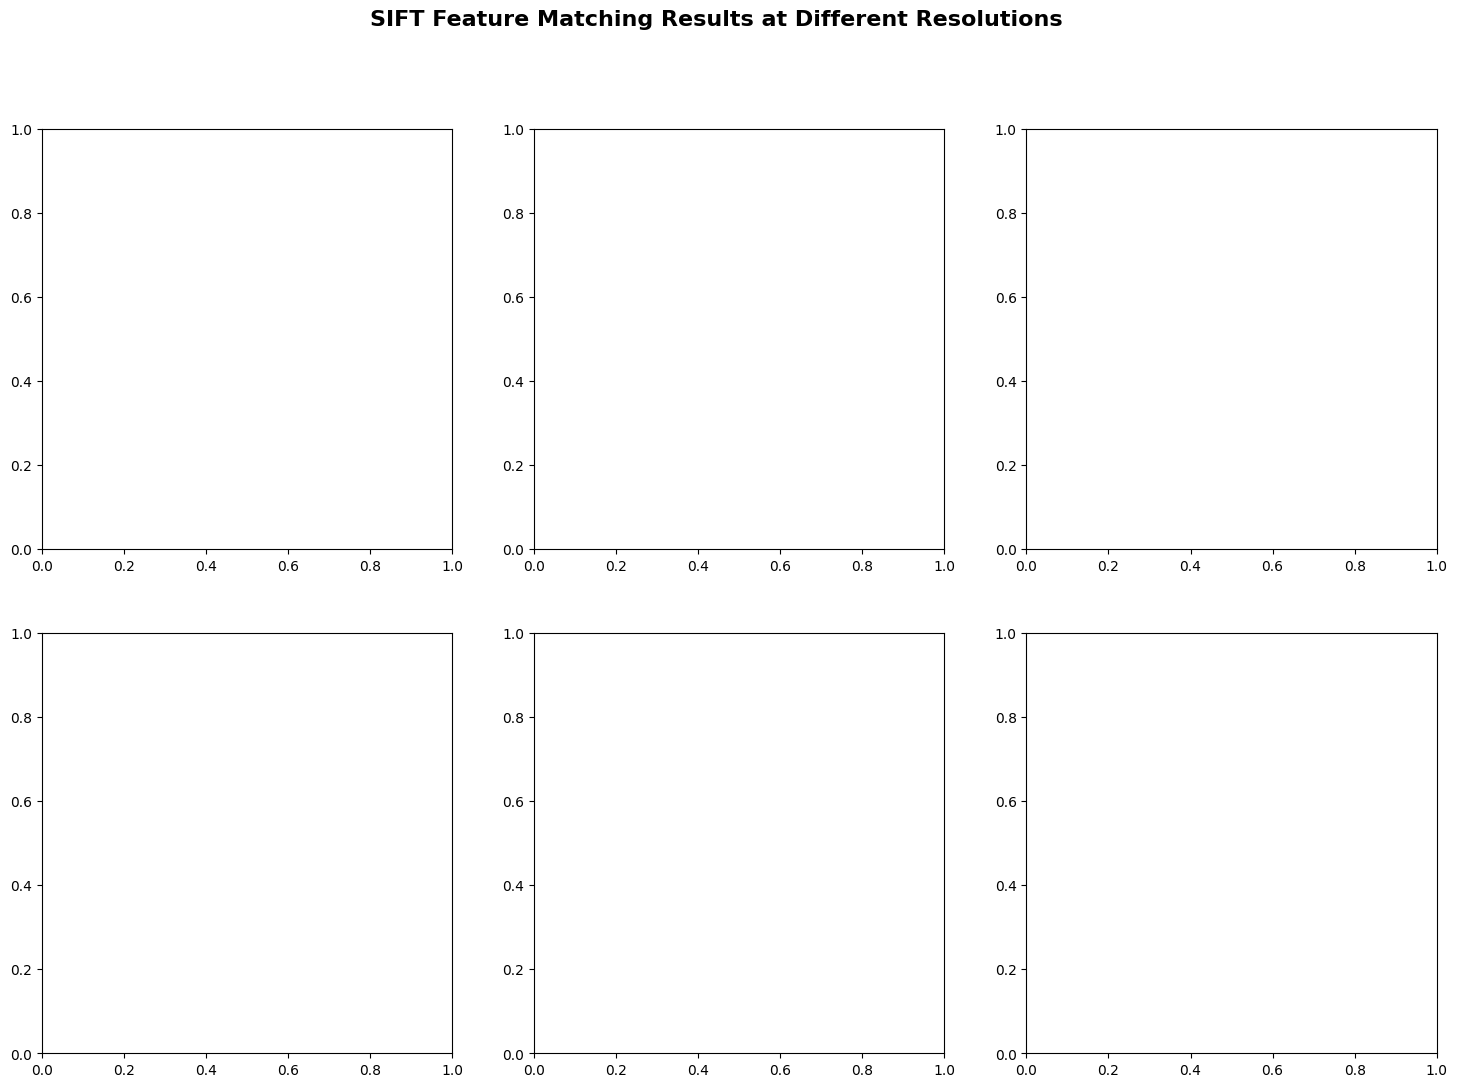

In [8]:
# Create summary visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('SIFT Feature Matching Results at Different Resolutions', fontsize=16, fontweight='bold')

for ortho_idx, ortho_name in enumerate(['no_gcps', 'with_gcps']):
    for res_idx, (res_name, factor) in enumerate(resolutions.items()):
        ax = axes[ortho_idx, res_idx]
        
        result = matching_results[ortho_name][res_name]
        
        if result['num_matches'] > 0 and result['offset_x'] is not None:
            # Load visualization if it exists
            vis_path = matches_dir / f"{ortho_name}_{res_name}_matches.jpg"
            if vis_path.exists():
                vis_img = plt.imread(vis_path)
                ax.imshow(vis_img)
                ax.axis('off')
                
                title = f"{ortho_name.replace('_', ' ').title()} - {res_name.title()}\n"
                title += f"Matches: {result['num_matches']}, "
                title += f"Offset: ({result['offset_x']:.1f}, {result['offset_y']:.1f}) px"
                ax.set_title(title, fontsize=10)
            else:
                ax.text(0.5, 0.5, f"No visualization\navailable", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{ortho_name} - {res_name}", fontsize=10)
        else:
            ax.text(0.5, 0.5, f"No matches found\n{result.get('error', '')}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{ortho_name} - {res_name}", fontsize=10)
            ax.axis('off')

plt.tight_layout()
summary_vis_path = matches_dir / "matching_summary.png"
plt.savefig(summary_vis_path, dpi=150, bbox_inches='tight')
plt.close()

print(f"✓ Summary visualization saved: {summary_vis_path}")

# Print summary table
print("\n" + "="*60)
print("Matching Results Summary")
print("="*60)

for ortho_name in ['no_gcps', 'with_gcps']:
    print(f"\n{ortho_name.replace('_', ' ').title()}:")
    print(f"  {'Resolution':<12} {'Matches':<10} {'Offset X':<12} {'Offset Y':<12} {'RMSE 2D':<12} {'Confidence':<10}")
    print(f"  {'-'*12} {'-'*10} {'-'*12} {'-'*12} {'-'*12} {'-'*10}")
    
    for res_name in ['full', 'half', 'quarter']:
        result = matching_results[ortho_name][res_name]
        matches = result['num_matches']
        offset_x = f"{result['offset_x']:.2f}" if result['offset_x'] is not None else "N/A"
        offset_y = f"{result['offset_y']:.2f}" if result['offset_y'] is not None else "N/A"
        rmse = f"{result['rmse_2d']:.2f}" if result['rmse_2d'] is not None else "N/A"
        conf = f"{result['confidence']:.3f}" if result['confidence'] else "0.000"
        
        print(f"  {res_name:<12} {matches:<10} {offset_x:<12} {offset_y:<12} {rmse:<12} {conf:<10}")


## Step 7: Apply 2D Shift and Register Orthomosaics


In [ ]:
def apply_2d_shift_to_image(img: np.ndarray, shift_x: float, shift_y: float) -> np.ndarray:
    """
    Apply 2D shift to an image.
    
    Args:
        img: Input image array
        shift_x: Shift in X direction (pixels)
        shift_y: Shift in Y direction (pixels)
        
    Returns:
        Shifted image
    """
    try:
        from scipy.ndimage import shift
        use_scipy = True
    except ImportError:
        use_scipy = False
    
    if use_scipy:
        if len(img.shape) == 3:
            # RGB image
            shifted = np.zeros_like(img)
            for i in range(img.shape[2]):
                shifted[:, :, i] = shift(img[:, :, i], (shift_y, shift_x), mode='constant', cval=0, order=1)
        else:
            # Grayscale
            shifted = shift(img, (shift_y, shift_x), mode='constant', cval=0, order=1)
    else:
        # Fallback: integer shift using numpy
        shift_x_int = int(round(shift_x))
        shift_y_int = int(round(shift_y))
        
        if len(img.shape) == 3:
            shifted = np.zeros_like(img)
            h, w = img.shape[:2]
            if shift_y_int >= 0 and shift_x_int >= 0:
                shifted[shift_y_int:, shift_x_int:] = img[:h-shift_y_int, :w-shift_x_int]
            elif shift_y_int < 0 and shift_x_int < 0:
                shifted[:h+shift_y_int, :w+shift_x_int] = img[-shift_y_int:, -shift_x_int:]
            else:
                # Handle other cases
                if shift_y_int >= 0:
                    shifted[shift_y_int:, :] = img[:h-shift_y_int, :]
                if shift_x_int >= 0:
                    shifted[:, shift_x_int:] = img[:, :w-shift_x_int]
        else:
            shifted = np.zeros_like(img)
            h, w = img.shape
            if shift_y_int >= 0 and shift_x_int >= 0:
                shifted[shift_y_int:, shift_x_int:] = img[:h-shift_y_int, :w-shift_x_int]
            elif shift_y_int < 0 and shift_x_int < 0:
                shifted[:h+shift_y_int, :w+shift_x_int] = img[-shift_y_int:, -shift_x_int:]
    
    return shifted

# Choose best resolution for registration (prefer full res if available, otherwise use best match count)
registered_orthos = {}

for ortho_name in ['no_gcps', 'with_gcps']:
    print(f"\n{'='*60}")
    print(f"Registering {ortho_name}...")
    print(f"{'='*60}")
    
    # Find best resolution (prefer full, then highest match count)
    best_res = None
    best_matches = 0
    
    for res_name in ['full', 'half', 'quarter']:
        result = matching_results[ortho_name][res_name]
        if result['num_matches'] > best_matches and result['offset_x'] is not None:
            best_matches = result['num_matches']
            best_res = res_name
    
    if best_res is None:
        print(f"  ⚠️  No valid matches found for {ortho_name}")
        continue
    
    result = matching_results[ortho_name][best_res]
    print(f"  Using {best_res} resolution results (matches: {result['num_matches']})")
    
    # Get full resolution offset
    shift_x = result['offset_x_full']
    shift_y = result['offset_y_full']
    
    print(f"  Applying shift: X={shift_x:.2f} px, Y={shift_y:.2f} px")
    
    # Load full resolution image
    ortho_img = converted_files['full'][ortho_name]['img']
    
    # Apply shift
    shifted_img = apply_2d_shift_to_image(ortho_img, shift_x, shift_y)
    
    # Save registered image
    registered_path = registered_dir / f"{ortho_name}_registered.jpg"
    
    if len(shifted_img.shape) == 3:
        img_pil = Image.fromarray(shifted_img)
    else:
        img_pil = Image.fromarray(shifted_img).convert('RGB')
    
    img_pil.save(registered_path, 'JPEG', quality=95)
    print(f"  ✓ Saved registered image: {registered_path}")
    
    registered_orthos[ortho_name] = {
        'path': registered_path,
        'img': shifted_img,
        'shift_x': shift_x,
        'shift_y': shift_y,
        'resolution_used': best_res
    }

print(f"\n✓ Registration complete!")


## Step 8: Create Final Visualizations


In [ ]:
# Create side-by-side comparison: original vs registered
for ortho_name in ['no_gcps', 'with_gcps']:
    if ortho_name not in registered_orthos:
        continue
    
    print(f"\nCreating visualization for {ortho_name}...")
    
    # Load images (use full resolution)
    original_img = converted_files['full'][ortho_name]['img']
    registered_img = registered_orthos[ortho_name]['img']
    basemap_img = converted_files['full']['basemap']['img']
    
    # Resize to same size for comparison (use smallest)
    min_h = min(original_img.shape[0], registered_img.shape[0], basemap_img.shape[0])
    min_w = min(original_img.shape[1], registered_img.shape[1], basemap_img.shape[1])
    
    original_resized = cv2.resize(original_img, (min_w, min_h))
    registered_resized = cv2.resize(registered_img, (min_w, min_h))
    basemap_resized = cv2.resize(basemap_img, (min_w, min_h))
    
    # Create comparison figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle(f'Registration Results: {ortho_name.replace("_", " ").title()}', fontsize=16, fontweight='bold')
    
    # Basemap (ground truth)
    axes[0, 0].imshow(basemap_resized)
    axes[0, 0].set_title('Ground Truth Basemap', fontweight='bold')
    axes[0, 0].axis('off')
    
    # Original ortho
    axes[0, 1].imshow(original_resized)
    axes[0, 1].set_title('Original Orthomosaic', fontweight='bold')
    axes[0, 1].axis('off')
    
    # Registered ortho
    axes[1, 0].imshow(registered_resized)
    shift_info = registered_orthos[ortho_name]
    title = f"Registered Orthomosaic\n"
    title += f"Shift: ({shift_info['shift_x']:.2f}, {shift_info['shift_y']:.2f}) px\n"
    title += f"Resolution: {shift_info['resolution_used']}"
    axes[1, 0].set_title(title, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Difference map
    diff = np.abs(registered_resized.astype(float) - basemap_resized.astype(float))
    diff_norm = (diff / diff.max() * 255).astype(np.uint8) if diff.max() > 0 else diff.astype(np.uint8)
    axes[1, 1].imshow(diff_norm, cmap='hot')
    axes[1, 1].set_title('Difference Map (Registered vs Basemap)', fontweight='bold')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    
    comparison_path = registered_dir / f"{ortho_name}_comparison.png"
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"  ✓ Saved comparison: {comparison_path}")

# Save matching results to JSON
results_json_path = matching_output_dir / "matching_results.json"

def convert_to_native(obj):
    """Convert numpy types to native Python types for JSON."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_native(item) for item in obj]
    elif hasattr(obj, '__dict__'):
        # Handle OpenCV keypoints (skip them for JSON)
        return None
    return obj

# Clean results for JSON (remove OpenCV objects)
json_results = {}
for ortho_name in matching_results:
    json_results[ortho_name] = {}
    for res_name in matching_results[ortho_name]:
        result = matching_results[ortho_name][res_name].copy()
        # Remove OpenCV objects
        result.pop('kp1', None)
        result.pop('kp2', None)
        result.pop('good_matches', None)
        json_results[ortho_name][res_name] = convert_to_native(result)

with open(results_json_path, 'w') as f:
    json.dump(json_results, f, indent=2)

print(f"\n✓ Results saved to: {results_json_path}")
print(f"\n{'='*60}")
print("✓ Feature Matching and Registration Complete!")
print(f"{'='*60}")
